# AUTHOR
***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-06-20**

# Implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

np.seterr(divide='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
# fruits dataset
train_inp = np.load("/content/drive/MyDrive/AI training by HST/datasets/dataset_inputs.npy")
train_out = np.load("/content/drive/MyDrive/AI training by HST/datasets/dataset_outputs.npy")
train_out = train_out.astype(np.int64)
train_inp = train_inp / 255

In [ ]:
# MNIST dataset
(X_mnist, y_mnist), (X_test, y_test) = mnist.load_data()
X_train, y_train = X_mnist[:1000,:], y_mnist[:1000]
X_test, y_test = X_test[:150,:], y_test[:150]

X_train = X_train.reshape(*X_train.shape, 1) / 255
X_test = X_test.reshape(*X_test.shape, 1) / 255

In [ ]:
X_train.shape

(1000, 28, 28, 1)

In [ ]:
y_test

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4,
       8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6,
       5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2], dtype=uint8)

# Activation functions

In [ ]:
# activation functions
def linear(Z):
  return Z

def sigmoid(Z):
  return 1.0 / (1 + np.exp(-Z))

def relu(Z):
  Z[Z < 0] = 0
  return Z

def leakyrelu(Z, alpha=0.01):
  Z[Z < 0] = Z[Z < 0] * alpha
  return Z

def stable_softmax(Z):
  e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
  return e_Z / e_Z.sum(axis = 0, keepdims = True)

activations = {'linear': linear, 'sigmoid': sigmoid, 'relu': relu, 'leaky_relu': leakyrelu, 'softmax': stable_softmax}

# derivatives
def linear_grad(Z):
  return np.ones_like(Z)

def sigmoid_grad(Z):
  o = sigmoid(Z)
  return o * (1 - o)

def relu_grad(Z):
  result = np.ones_like(Z)
  result[Z < 0] = 0
  return result

def leakyrelu_grad(Z, alpha=0.01):
  result = np.ones_like(Z)
  result[Z < 0] = alpha
  return result

def stable_softmax_grad(Z):
  pass

derivatives = {'linear': linear_grad, 'sigmoid': sigmoid_grad, 'relu': relu_grad, 'leaky_relu': leakyrelu_grad, 'softmax': stable_softmax_grad}

# Layers

In [ ]:
class PseudoLayer:
  output = None
  output_shape = None

  def __init__(self, data=None, data_shape=None):
    self.output = data
    self.output_shape = data_shape

  def set_(self, data, data_shape):
    self.output = data
    self.output_shape = data_shape

class Entry:
  """
  Implementation of the input layer of a CNN.
  The CNN must start with an input layer.
  """

  __name__ = "Entry"
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.output_shape = input_shape
  
  def calc_(self, input_data):
    self.output = input_data

class Conv2D:
  """
  The convolution layer implementation (inspired by Keras).
  Owner: @hsthe29
  """

  __name__ = "Conv2D"

  # Attributes
  previous_layer = None
  output = None # A

  def __init__(self, num_filters, kernel_size, activation='linear', padding=0, stride=1):
    """

    Args:
        num_filters: Number of filters in the convolution layer.
        kernel_size: Kernel size of the filter.
        previous_layer: A reference to the previous layer.
        activation (str, optional): The activation function to be used in the conv layer. Defaults to 'linear'.
        padding: Padding, needs for convolution computation. Defaults to 0.
        stride: Stride, needs for convolution computation. Defaults to 1.

    """

    if num_filters <= 0:
      raise ValueError('Number of filters must be a positive integer!')
    if kernel_size <= 0:
      raise ValueError('Kernel size must be a positive integer!')
    if activation is None:
      raise ValueError('Activation function must not be None!')
    if activation not in activations.keys():
      raise ValueError('Invalid activation function!')

    self.num_filters = num_filters
    self.kernel_size = kernel_size
    self.activation = activations[activation]
    self.p = padding
    self.s = stride

  def connect_layer(self, previous_layer):
    self.previous_layer = previous_layer
    if len(previous_layer.output_shape) <= 2:
      raise ValueError('len output shape must be 3.')

    self.filters_shape = (self.num_filters, self.kernel_size, self.kernel_size, self.previous_layer.output_shape[-1])

    self.initial_filters = np.random.uniform(low=-0.5, high=0.5, size=self.filters_shape)
    self.__filters = self.initial_filters.copy()

    self.input_shape = previous_layer.output_shape

    temp_os1 = (previous_layer.output_shape[0] + 2*self.p - self.kernel_size) // self.s + 1
    temp_os2 = (previous_layer.output_shape[1] + 2*self.p - self.kernel_size) // self.s + 1
    self.output_shape = (temp_os1, temp_os2, self.num_filters)

  def calc_(self):
    """
    Convolves the previous_layer's output by a filter bank.
    Variable self.Z saves the result of convolving the input by the filter bank.
    Variable self.output save the resulf of Z after applying activation function.
    """

    # handle input ...

    input_data = self.previous_layer.output

    # input_data : (n, 100, 100, 3)

    depth = input_data.shape[2]
    X = np.dstack(tuple([np.pad(input_data[:, :, i], pad_width=self.p, mode='constant', 
                  constant_values=0) for i in range(depth)]))

    self.Z = np.zeros(self.output_shape, dtype=np.float64)

    h = self.filters_shape[1] >> 1

    yH, yW = self.output_shape[:2]
    for i in range(0, yH):
      for j in range(0, yW):
        ci, cj = h + self.s*i, h + self.s*j
        A = X[ci-h:ci+h+1, cj-h:cj+h+1]

        for filter_index in range(self.num_filters):
          conv_sum = np.sum(A * self.__filters[filter_index])
          self.Z[i, j, filter_index] = conv_sum
      
    self.output = self.activation(self.Z)

class AveragePooling:
  """
  The average pooling layer implementation.
  """

  __name__ = "AveragePooling"

  # Attributes
  previous_layer = None
  output = None # A

  def __init__(self, pool_shape, padding=0, stride=2):
    """

    Args:
        pool_shape(int): size pool matrix
        previous_layer: Reference to the previous layer in the CNN.
        padding (int): Padding. Defaults to 0.
        stride (int): Stride. Defaults to 2.
    """
    self.pool_shape = pool_shape
    self.p = padding
    self.s = stride

  def connect_layer(self, previous_layer):
    self.previous_layer = previous_layer
    self.input_shape = previous_layer.output_shape
    temp_os1 = (previous_layer.output_shape[0] + 2*self.p - self.pool_shape) // self.s + 1
    temp_os2 = (previous_layer.output_shape[1] + 2*self.p - self.pool_shape) // self.s + 1
    self.output_shape = (temp_os1, temp_os2, previous_layer.output_shape[-1])
  
  def calc_(self):
    """
    Applies the average pooling operation.
    """

    input_data = self.previous_layer.output
    self.output = np.zeros(self.output_shape, dtype=np.float64)

    depth = input_data.shape[2] if len(input_data.shape) > 2 else 1
    X = np.dstack(tuple([np.pad(input_data[:, :, i], pad_width=self.p, mode='constant', 
                  constant_values=0) for i in range(depth)]))

    yH, yW, yZ = self.output_shape
    for i in range(yH):
      for j in range(yW):
        for k in range(yZ):
          yx = i * self.s
          yy = j * self.s
          self.output[i, j, k] = np.mean(X[yx, yy, k])

class MaxPooling:
  """
  The max pooling layer implementation.
  """

  __name__ = "MaxPooling"

      # Attributes
  previous_layer = None
  output = None # A

  def __init__(self, pool_shape, padding=0, stride=2):
    """

    Args:
        pool_shape(int): size pool matrix
        previous_layer: Reference to the previous layer in the CNN.
        padding (int): Padding. Defaults to 0.
        stride (int): Stride. Defaults to 2.
    """

    self.pool_shape = pool_shape
    self.p = padding
    self.s = stride
    
  def connect_layer(self, previous_layer):
    self.previous_layer = previous_layer
    self.input_shape = previous_layer.output_shape
    temp_os1 = (previous_layer.output_shape[0] + 2*self.p - self.pool_shape) // self.s + 1
    temp_os2 = (previous_layer.output_shape[1] + 2*self.p - self.pool_shape) // self.s + 1
    self.output_shape = (temp_os1, temp_os2, previous_layer.output_shape[-1])
  
  def calc_(self):
    """
    Applies the max pooling operation.
    """
    input_data = self.previous_layer.output
    self.output = np.zeros(self.output_shape, dtype=np.float64)

    depth = input_data.shape[2] if len(input_data.shape) > 2 else 1
    X = np.dstack(tuple([np.pad(input_data[:, :, i], pad_width=self.p, mode='constant', 
                  constant_values=0) for i in range(depth)]))

    yH, yW, yZ = self.output_shape
    for i in range(yH):
      for j in range(yW):
        for k in range(yZ):
          yx = i * self.s
          yy = j * self.s
          self.output[i, j, k] = np.max(X[yx, yy, k])

class Flatten:
  """
  The flatten layer implementation.
  """

  __name__ = "Flatten"

  # Attributes
  previous_layer = None
  output = None # A

  def __init__(self):
    """

    Args:
        previous_layer: Reference to the previous layer in the CNN.
    """
    pass

  def connect_layer(self, previous_layer):
    self.previous_layer = previous_layer
    self.input_shape = previous_layer.output_shape
    self.output_shape = (np.prod(previous_layer.output_shape), 1)

  def calc_(self):
    """
    Flatten output of last Conv2D layer as input of dense (fully connected) layers. 
    """

    input_data = self.previous_layer.output
    self.output = np.ravel(input_data).reshape(-1, 1)
    # print("after ravel(): ", self.output.shape)

class Dense:
  """
  The fully connected (dense) layer implementation.
  """

  __name__ = "Dense"

  # Attributes
  previous_layer = None
  output = None # A

  def __init__(self, n_units, coeff=0.1, activation="relu"):
    """

    Args:
        n_units (int, > 0): number of units in Dense layer.
        previous_laye: Reference to the previous layer in the CNN.
        activation: The activation function to be used in this Dense layer. Defaults to "relu".
    """
    # Number of units in the dense layer.
    self.n_units = n_units
    self.coeff_ = coeff

    # Validating the activation function
    if activation not in activations.keys():
      raise ValueError('Invalid activation function!')

    self.activation = activations[activation]
    self.grad = derivatives[activation]
  
  def connect_layer(self, previous_layer):
    self.previous_layer = previous_layer
    
    # Initializing the weights of the layer.
    self.initial_weights = self.coeff_ * np.random.randn(self.previous_layer.output_shape[0], self.n_units)
    self.initial_bias = np.zeros((self.n_units, 1))
    self.weights = self.initial_weights.copy()
    self.b = self.initial_bias.copy()
    self.input_shape = self.previous_layer.output_shape
    self.output_shape = (self.n_units, self.previous_layer.output_shape[1])

  def calc_(self):
    """
    Computes the output of the dense layer.
    Input of this layer is output of previous layer. 
    Variable self.Z saves the result of this layer.
    Variable self.output save the resulf of Z after applying activation function.
    """

    # [d, n]
    input_data = self.previous_layer.output 

    self.Z = self.weights.T @ input_data + self.b # d(l+1), d(l)  x d(l), 1 = d(l+1), 1
    self.output = self.activation(self.Z)


# Convolutional Neural Network Model

In [ ]:
class CNN_Model:
  """
  My Convolutional Neural Network Model.
  """

  __version__ = '1.0.0'
  __author__ = 'hsthe29'

  def __init__(self):
    """
    Initialize necessary variables and data structures.
    """

    self.feature_layers = []
    self.dense_layers = [PseudoLayer()]
    self.n_layers = 0
    self.loss = []
    self.__convolved_data = []
  
  def get_last_layer(self):
    """
    Get the last layer of model.

    Returns:
        Layer: currently lastest layer.
    """
    if self.dense_layers is None:
      raise TypeError("Dense layers have not been initialized yet!")

    return self.dense_layers[-1]

  def add(self, layer):
    """
    Adds layer into model.

    Args:
        layers: The layer of CNN model.
    """

    if layer.__name__ != 'Dense':
      # if len(self.feature_layers) > 0:
        # layer.connect_layer(self.feature_layers[-1])
      self.feature_layers.append(layer)
    else:
      # layer.connect_layer(self.dense_layers[-1])
      self.dense_layers.append(layer)
    self.n_layers += 1

  def __cal_cross_entropy_loss(self, y_hat, y):
    """
    Calculates loss value of this Network.

    Args:
        Y: true output.
        Yh: trained output.

    Returns:
        np.float64: loss value.
    """
    idx = np.arange(len(y))
    return -np.sum(np.log(y_hat[y, idx]))

  def __convolve(self, x):
    self.feature_layers[0].calc_(x)

    for layer in self.feature_layers[1:]:
      layer.calc_()
    
    return self.feature_layers[-1].output

  def __feed_forward(self, x, y): # n data points
    # x [C, n], y[n]
    """_summary_

    Args:
        x (_type_): mini batch data
        y (_type_): _description_

    Returns:
        _type_: _description_
    """

    self.dense_layers[0].set_(x, x.shape)

    for layer in self.dense_layers[1:]:
        layer.calc_()

    # [C, n] 
    error = self.__cal_cross_entropy_loss(self.dense_layers[-1].output, y)
    return error

  def __backpropagation(self, y):
    """
    Performs backpropagation for Dense layers (may be also Conv2D layers).

    Args:
        x: order of current input being trained.
        y: 
    """
    Y = np.zeros((self.dense_layers[-1].n_units, len(y))) # [C, n]
    Y[y, np.arange(len(y))] = 1

    # A = np.max(np.abs(self.net_layers[-1].output)) 
    E = (self.dense_layers[-1].output - Y) # (C, n)

    dWL = self.dense_layers[-2].output @ E.T # (d1, n) x (n, C) = (d1, C)
    dbL = np.sum(E, axis=1, keepdims=True)

    dw = [(len(self.dense_layers) - 1, dWL)]
    db = [(len(self.dense_layers) - 1, dbL)]

    for ind in range(len(self.dense_layers) - 2, 0, -1):
      E = self.dense_layers[ind + 1].weights @ E
      E = E * self.dense_layers[ind].grad(self.dense_layers[ind].Z)
      dWl = self.dense_layers[ind - 1].output @ E.T
      dbl = np.sum(E, axis=1, keepdims=True)
      dw.append((ind, dWl))
      db.append((ind, dbl))

    for i, w in dw:
      self.dense_layers[i].weights -= self.lr * w

    for i, b in db:
      self.dense_layers[i].b -= self.lr * b

  
  def fit(self, X_train, y_train, batch_size=1, num_epochs=1001, learning_rate=1e-2, show_progress=False):
    """
    Trains the CNN model.

    Args:
        X: Training data inputs.
        y: Training data outputs.
        num_epochs (int, > 1): number of epochs. Defaults to 1001.
        learning_rate (_float64): learning rate. Defaults to 1e-2.
        show_progress (bool): Choose whether to show the execution or not. Defaults to False.
    """
    if batch_size < 1 or not isinstance(batch_size, int) or X_train.shape[0] % batch_size != 0:
      raise ValueError("Invalid batch_size value!")

    

    for i in range(1, len(self.feature_layers)):
      self.feature_layers[i].connect_layer(self.feature_layers[i - 1])

    self.dense_layers[0].output_shape = (self.feature_layers[-1].output_shape[0], batch_size)

    for i in range(1, len(self.dense_layers)):
      self.dense_layers[i].connect_layer(self.dense_layers[i - 1])

    self.lr = learning_rate
    N = X_train.shape[0]

    for i in range(N):
      self.__convolved_data.append(self.__convolve(X_train[i]))
    
    self.__convolved_data = np.asarray(self.__convolved_data)

    _x, _y, _ = self.__convolved_data.shape

    self.__convolved_data = self.__convolved_data.reshape(_x, _y).T

    iter_per_epoch: int = X_train.shape[0] // batch_size

    for epoch in range(num_epochs):
      acc_classes = np.zeros_like(y_train)
      ran_id = np.random.permutation(N)
      temp = 0.0
      for i in range(iter_per_epoch):
        _id = ran_id[i * batch_size: (i + 1) * batch_size]
        X_featured = self.__convolved_data[:, _id]
        y_featured = y_train[_id]

        temp += self.__feed_forward(X_featured, y_featured)
        self.__backpropagation(y_featured)
        acc_classes[_id] = np.argmax(self.dense_layers[-1].output, axis=0)
      
      self.loss.append(temp / N)
      
      
      if show_progress:
        print(f'epoch: {epoch: ^ 5}, loss: {self.loss[-1]}, acc: {accuracy_score(acc_classes, y_train)}')

  def __predict(self, X):
    """
    Computes the class-to-class probabilities of each input.

    Args:
        X: image input. Defaults to None that means self.X (train data) will be used. 

    Returns:
        tensor (num_classes, n_data): probabilities matrix.
    """
    

    if X is None:
      X = self.X

    N = X.shape[0]
    res = np.zeros((self.dense_layers[-1].n_units, N))
    for i in range(N):
      data = X[i]
      self.feature_layers[0].calc_(data)

      for layer in self.feature_layers[1:]:
        layer.calc_()

      self.dense_layers[0].set_(self.feature_layers[-1].output, self.feature_layers[-1].output_shape)

      for layer in self.dense_layers[1:]:
        layer.calc_()

      res[:, i] = self.dense_layers[-1].output.ravel()
    return res

  def predict(self, X):
    """
    Gets vector of predicted output of X.

    Args:
        X: input

    Returns:
        vector: predicted output.
    """
    return np.argmax(self.__predict(X), axis=0)

# Train model

## Fruits dataset

In [ ]:
n_classes = 4

model = CNN_Model()

model.add(Entry((100, 100, 3)))
model.add(Conv2D(num_filters=2, kernel_size=3, activation='relu'))
model.add(AveragePooling(pool_shape=2))
model.add(Conv2D(num_filters=3, kernel_size=3, activation='relu'))
model.add(MaxPooling(pool_shape=2))
model.add(Flatten())
# Fully connected layers
model.add(Dense(n_units=50, activation='relu'))
model.add(Dense(n_units=n_classes, activation='softmax'))

model.fit(train_inp, train_out, num_epochs=10, learning_rate=0.01, show_progress=True)

epoch:   0  , loss: 1.324607523867741, acc: 0.375
epoch:   1  , loss: 1.1267846182763326, acc: 0.8
epoch:   2  , loss: 0.9238437417392186, acc: 0.8625
epoch:   3  , loss: 0.7321343730606615, acc: 0.975
epoch:   4  , loss: 0.574527211077842, acc: 1.0
epoch:   5  , loss: 0.4495205433601668, acc: 1.0
epoch:   6  , loss: 0.3516474806312307, acc: 1.0
epoch:   7  , loss: 0.2773215840720251, acc: 1.0
epoch:   8  , loss: 0.2218793573919465, acc: 1.0
epoch:   9  , loss: 0.17949238220420183, acc: 1.0


In [ ]:
y_pred = model.predict(train_inp)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


In [ ]:
print(accuracy_score(train_out, y_pred))

1.0


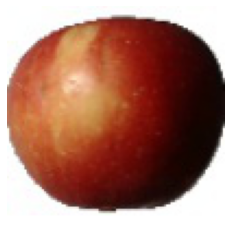

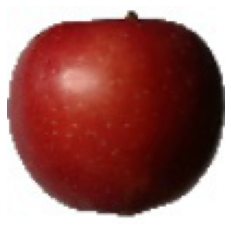

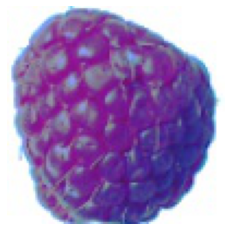

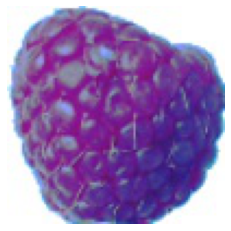

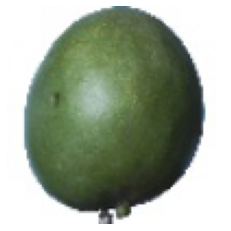

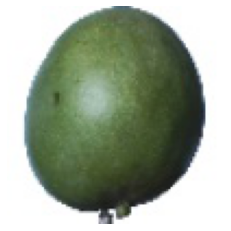

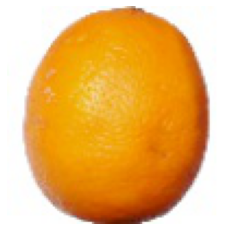

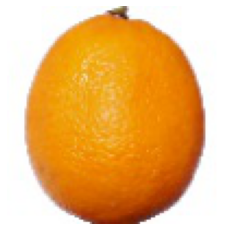

In [ ]:
def exactor(X):
    return X.astype(np.uint8)
  
sample_img = [0, 1, 20, 21, 40, 41, 60, 61]

for i in sample_img:
    img = train_inp[i]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

## MNIST dataset

In [ ]:
C = 10 # number of classes

model_2 = CNN_Model()

model_2.add(Entry((28, 28, 1)))
model_2.add(Conv2D(num_filters=10, kernel_size=3, activation='relu', padding=1))
# model.add(AveragePooling(pool_shape=2, previous_layer=model.get_last_layer()))
model_2.add(Conv2D(num_filters=20, kernel_size=3, activation='relu', padding=1))
model_2.add(MaxPooling(pool_shape=2))
model_2.add(Flatten())
# Fully connected layers
model_2.add(Dense(n_units=100, coeff=0.0001, activation='relu'))
model_2.add(Dense(n_units=C, coeff=0.005, activation='softmax'))

model_2.fit(X_train, y_train, batch_size=100, num_epochs=20, learning_rate=0.02, show_progress=True)

epoch:   0  , loss: 2.214317340744506, acc: 0.183
epoch:   1  , loss: 1.602228127579421, acc: 0.446
epoch:   2  , loss: 1.2264954218821524, acc: 0.614
epoch:   3  , loss: 0.8066466617865787, acc: 0.759
epoch:   4  , loss: 0.4446452570233647, acc: 0.884
epoch:   5  , loss: 0.4383430005416114, acc: 0.885
epoch:   6  , loss: 0.30578388143195456, acc: 0.913
epoch:   7  , loss: 0.23306490541017338, acc: 0.936
epoch:   8  , loss: 0.1806733961078682, acc: 0.953
epoch:   9  , loss: 0.09099630446688636, acc: 0.978
epoch:   10 , loss: 0.0805588955658174, acc: 0.977
epoch:   11 , loss: 0.05462974097703147, acc: 0.987
epoch:   12 , loss: 0.02730954513917521, acc: 0.997
epoch:   13 , loss: 0.017440623379611195, acc: 1.0
epoch:   14 , loss: 0.012457692686086298, acc: 1.0
epoch:   15 , loss: 0.009529544704400802, acc: 1.0
epoch:   16 , loss: 0.0074806784209804945, acc: 1.0
epoch:   17 , loss: 0.0060529054261956785, acc: 1.0
epoch:   18 , loss: 0.005286626004741289, acc: 1.0
epoch:   19 , loss: 0.0046

In [ ]:
y_pred = model_2.predict(X_test)

print(f'{accuracy_score(y_pred, y_test) * 100} %') 

84.0 %


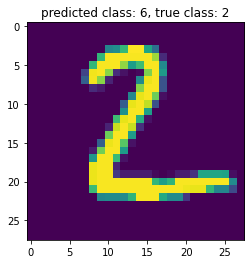

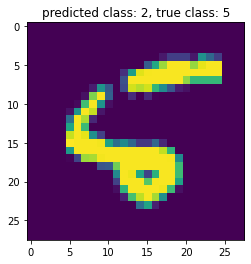

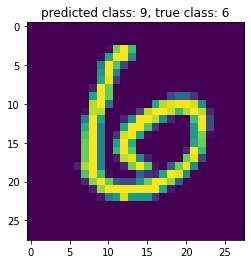

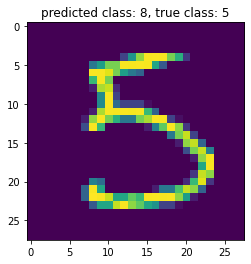

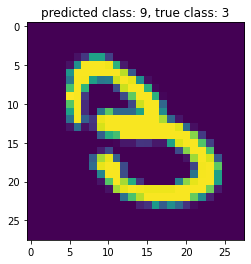

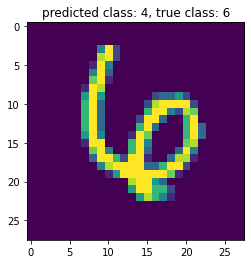

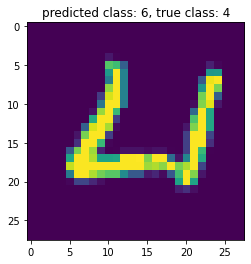

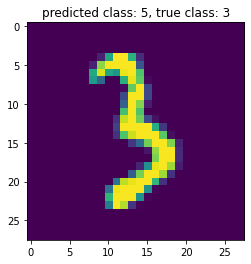

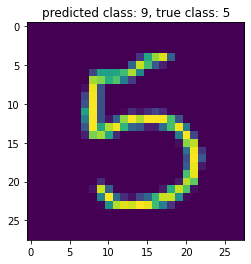

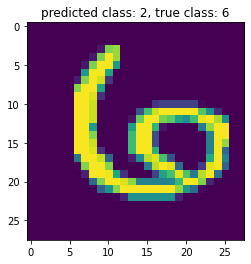

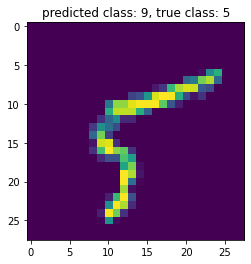

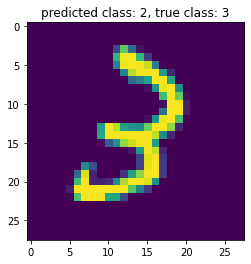

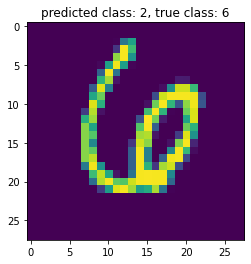

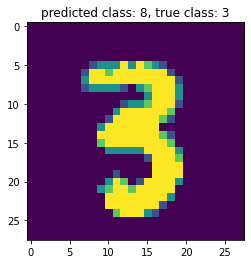

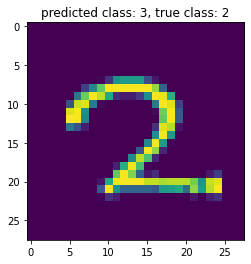

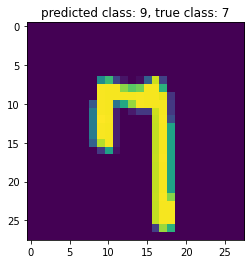

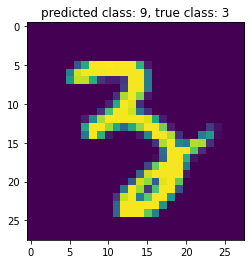

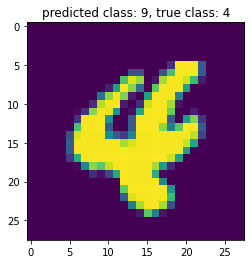

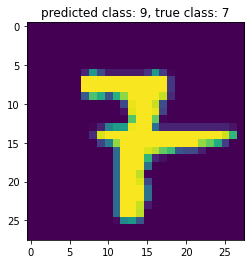

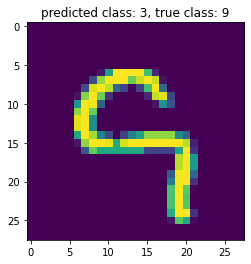

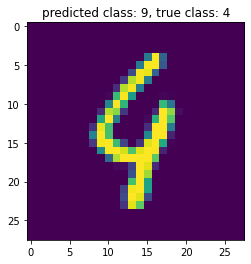

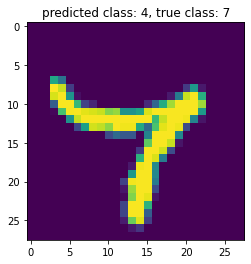

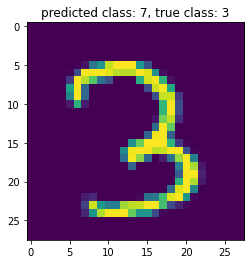

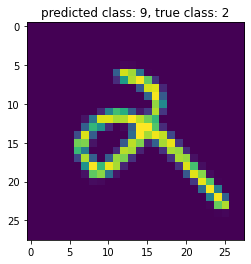

In [ ]:
def show_missclasssified_image(predicted_labels, true_labels):
  for i in range(len(true_labels)):
    if predicted_labels[i] != true_labels[i]:
      plt.title(f'predicted class: {predicted_labels[i]}, true class: {true_labels[i]}')
      plt.imshow(X_test[i].reshape(28, 28))
    plt.show()

show_missclasssified_image(y_pred, y_test)

# UPDATING
- for version 1.1